# Game 1 - Spectrum Labeling

What makes a situation safe? What makes it different? Can you develop a program to navigate future pandemics?
Recent events have demonstrated an ongoing struggle to determine what is "safe" during a pandemic. In this game, contestants will be tasked with utilizing readily available information, such as 100+ pages of the CDC Guidelines, and developing an algorithm to map a spectrum of scenarios, from safe to dangerous, to reduce the spread of COVID-19.

## brainstorming
- pdf scraper
- multi-class classification?  Logistic regression? Recommender system?
- bag of words, N-Grams, Tf-Idf

Delete cells below, this is just a dummy example.

In [8]:
import numpy as np
import seaborn as sns

In [5]:
a = np.arange(20)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [6]:
b = np.random.rand(20)
b

array([0.08619259, 0.19883055, 0.67624145, 0.79017984, 0.72322047,
       0.84855869, 0.01464436, 0.54682573, 0.42597452, 0.95654231,
       0.05105606, 0.22933428, 0.02829027, 0.76727093, 0.61746609,
       0.63010015, 0.2710247 , 0.12097698, 0.40293704, 0.92013697])

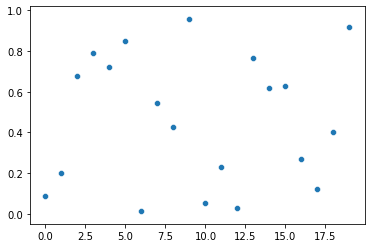

In [11]:
sns.scatterplot(x=a, y=b)